In [23]:
# ============================
# Classificação de Imagens - CIFAR-10 com CNN aprimorada
# ============================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [24]:
# ----------------------------
# 1. Carregar e preparar os dados
# ----------------------------
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_names = ['avião','carro','pássaro','gato','cervo',
               'cachorro','sapo','cavalo','navio','caminhão']

# Normalizar
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encoding
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Dividir treino/validação (80/20)
x_train, x_val, y_train_cat, y_val = train_test_split(
    x_train, y_train_cat, test_size=0.2, random_state=42
)

print("Shape treino:", x_train.shape, y_train_cat.shape)
print("Shape validação:", x_val.shape, y_val.shape)
print("Shape teste:", x_test.shape, y_test_cat.shape)

Shape treino: (40000, 32, 32, 3) (40000, 10)
Shape validação: (10000, 32, 32, 3) (10000, 10)
Shape teste: (10000, 32, 32, 3) (10000, 10)


In [25]:
# ----------------------------
# 2. Data augmentation
# ----------------------------
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(x_train)

In [26]:
# ----------------------------
# 3. Construção do modelo CNN
# ----------------------------
weight_decay = 1e-4  # para L2

modelo = Sequential()

# Bloco 1
modelo.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
modelo.add(BatchNormalization())
modelo.add(Conv2D(32, (3, 3), activation='relu'))
modelo.add(BatchNormalization())
modelo.add(MaxPooling2D(pool_size=(2, 2)))
modelo.add(Dropout(0.25))

# Bloco 2
modelo.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
modelo.add(BatchNormalization())
modelo.add(Conv2D(64, (3, 3), activation='relu'))
modelo.add(BatchNormalization())
modelo.add(MaxPooling2D(pool_size=(2, 2)))
modelo.add(Dropout(0.25))

# Bloco 3
modelo.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
modelo.add(BatchNormalization())
modelo.add(Conv2D(128, (3, 3), activation='relu'))
modelo.add(BatchNormalization())
modelo.add(MaxPooling2D(pool_size=(2, 2)))
modelo.add(Dropout(0.4))

# Classificador final com L2
modelo.add(Flatten())
modelo.add(Dense(256, activation='relu', kernel_regularizer=l2(weight_decay)))
modelo.add(Dropout(0.5))
modelo.add(Dense(10, activation='softmax'))

modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelo.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,57

 Total params: 422,698 (1.61 MB)

 Trainable params: 421,802 (1.61 MB)

 Non-trainable params: 896 (3.50 KB)

In [27]:
# ----------------------------
# 4. Callbacks
# ----------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ModelCheckpoint("best_cifar10_cnn.h5", save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

In [29]:
# ----------------------------
# 5. Treinamento
# ----------------------------
batch_size = 64
epochs = 200

history = modelo.fit(
    datagen.flow(x_train, y_train_cat, batch_size=batch_size),
    validation_data=(x_val, y_val),
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2700 - loss: 2.2305

625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.2702 - loss: 2.2294 - val_accuracy: 0.3786 - val_loss: 1.8421 - learning_rate: 0.0010
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4475 - loss: 1.5610

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.4475 - loss: 1.5609 - val_accuracy: 0.5730 - val_loss: 1.2310 - learning_rate: 0.0010
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.5191 - loss: 1.3840 - val_accuracy: 0.5567 - val_loss: 1.3428 - learning_rate: 0.0010
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5837 - loss: 1.2200

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.5837 - loss: 1.2200 - val_accuracy: 0.6061 - val_loss: 1.1124 - learning_rate: 0.0010
Epoch 5/200
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6194 - loss: 1.1173

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.6194 - loss: 1.1172 - val_accuracy: 0.6719 - val_loss: 0.9567 - learning_rate: 0.0010
Epoch 6/200
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6439 - loss: 1.0542

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.6439 - loss: 1.0542 - val_accuracy: 0.7074 - val_loss: 0.8643 - learning_rate: 0.0010
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.6648 - loss: 0.9977 - val_accuracy: 0.6907 - val_loss: 0.9243 - learning_rate: 0.0010
Epoch 8/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.6803 - loss: 0.9679 - val_accuracy: 0.6789 - val_loss: 0.9939 - learning_rate: 0.0010
Epoch 9/200
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7007 - loss: 0.9055

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.7007 - loss: 0.9055 - val_accuracy: 0.7434 - val_loss: 0.7722 - learning_rate: 0.0010
Epoch 10/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7095 - loss: 0.8880 - val_accuracy: 0.7313 - val_loss: 0.8236 - learning_rate: 0.0010
Epoch 11/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7148 - loss: 0.8710

625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.7148 - loss: 0.8710 - val_accuracy: 0.7614 - val_loss: 0.7415 - learning_rate: 0.0010
Epoch 12/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7251 - loss: 0.8341 - val_accuracy: 0.7579 - val_loss: 0.7415 - learning_rate: 0.0010
Epoch 13/200
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7374 - loss: 0.8074

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.7374 - loss: 0.8074 - val_accuracy: 0.7772 - val_loss: 0.6591 - learning_rate: 0.0010
Epoch 14/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7469 - loss: 0.7858 - val_accuracy: 0.7770 - val_loss: 0.6861 - learning_rate: 0.0010
Epoch 15/200
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7495 - loss: 0.7663

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.7495 - loss: 0.7663 - val_accuracy: 0.7982 - val_loss: 0.6225 - learning_rate: 0.0010
Epoch 16/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7558 - loss: 0.7469 - val_accuracy: 0.7957 - val_loss: 0.6361 - learning_rate: 0.0010
Epoch 17/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7608 - loss: 0.7407

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.7608 - loss: 0.7407 - val_accuracy: 0.8074 - val_loss: 0.6071 - learning_rate: 0.0010
Epoch 18/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7652 - loss: 0.7293 - val_accuracy: 0.7891 - val_loss: 0.6582 - learning_rate: 0.0010
Epoch 19/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7683 - loss: 0.7132 - val_accuracy: 0.7463 - val_loss: 0.8110 - learning_rate: 0.0010
Epoch 20/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7749 - loss: 0.7105 - val_accuracy: 0.7963 - val_loss: 0.6269 - learning_rate: 0.0010
Epoch 21/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7808 - loss: 0.6895

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7808 - loss: 0.6895 - val_accuracy: 0.8047 - val_loss: 0.6030 - learning_rate: 0.0010
Epoch 22/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7826 - loss: 0.6737 - val_accuracy: 0.7951 - val_loss: 0.6394 - learning_rate: 0.0010
Epoch 23/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7857 - loss: 0.6758 - val_accuracy: 0.8005 - val_loss: 0.6424 - learning_rate: 0.0010
Epoch 24/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7897 - loss: 0.6596 - val_accuracy: 0.7805 - val_loss: 0.6959 - learning_rate: 0.0010
Epoch 25/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7908 - loss: 0.6536

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7908 - loss: 0.6536 - val_accuracy: 0.8100 - val_loss: 0.5937 - learning_rate: 0.0010
Epoch 26/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7962 - loss: 0.6438

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.7962 - loss: 0.6438 - val_accuracy: 0.8136 - val_loss: 0.5930 - learning_rate: 0.0010
Epoch 27/200
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8019 - loss: 0.6304

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.8019 - loss: 0.6304 - val_accuracy: 0.8209 - val_loss: 0.5809 - learning_rate: 0.0010
Epoch 28/200
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7959 - loss: 0.6295

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7959 - loss: 0.6295 - val_accuracy: 0.8205 - val_loss: 0.5695 - learning_rate: 0.0010
Epoch 29/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.8040 - loss: 0.6154 - val_accuracy: 0.8118 - val_loss: 0.5926 - learning_rate: 0.0010
Epoch 30/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8082 - loss: 0.6124

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.8082 - loss: 0.6124 - val_accuracy: 0.8243 - val_loss: 0.5500 - learning_rate: 0.0010
Epoch 31/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.8068 - loss: 0.6123 - val_accuracy: 0.7950 - val_loss: 0.6612 - learning_rate: 0.0010
Epoch 32/200
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8072 - loss: 0.6049

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.8072 - loss: 0.6049 - val_accuracy: 0.8386 - val_loss: 0.5042 - learning_rate: 0.0010
Epoch 33/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.8065 - loss: 0.5991 - val_accuracy: 0.8104 - val_loss: 0.6148 - learning_rate: 0.0010
Epoch 34/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.8117 - loss: 0.5986 - val_accuracy: 0.8156 - val_loss: 0.5984 - learning_rate: 0.0010
Epoch 35/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.8142 - loss: 0.5949 - val_accuracy: 0.8224 - val_loss: 0.5695 - learning_rate: 0.0010
Epoch 36/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.8126 - loss: 0.5885 - val_accuracy: 0.8331 - val_loss: 0.5363 - learning_rate: 0.0010
Epoch 37/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8166 - loss: 0.5812
Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.8166 - los

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.8420 - loss: 0.5062 - val_accuracy: 0.8496 - val_loss: 0.4843 - learning_rate: 5.0000e-04
Epoch 43/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8324 - loss: 0.5176

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.8324 - loss: 0.5176 - val_accuracy: 0.8498 - val_loss: 0.4713 - learning_rate: 5.0000e-04
Epoch 44/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.8437 - loss: 0.5002 - val_accuracy: 0.8413 - val_loss: 0.5069 - learning_rate: 5.0000e-04
Epoch 45/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.8389 - loss: 0.4997 - val_accuracy: 0.8489 - val_loss: 0.4799 - learning_rate: 5.0000e-04
Epoch 46/200
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8372 - loss: 0.5001

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.8372 - loss: 0.5001 - val_accuracy: 0.8531 - val_loss: 0.4705 - learning_rate: 5.0000e-04
Epoch 47/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.8445 - loss: 0.4887 - val_accuracy: 0.8470 - val_loss: 0.5030 - learning_rate: 5.0000e-04
Epoch 48/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.8446 - loss: 0.4847 - val_accuracy: 0.8526 - val_loss: 0.4728 - learning_rate: 5.0000e-04
Epoch 49/200
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8432 - loss: 0.4910

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.8432 - loss: 0.4910 - val_accuracy: 0.8669 - val_loss: 0.4203 - learning_rate: 5.0000e-04
Epoch 50/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.8494 - loss: 0.4763 - val_accuracy: 0.8565 - val_loss: 0.4572 - learning_rate: 5.0000e-04
Epoch 51/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.8450 - loss: 0.4856 - val_accuracy: 0.8489 - val_loss: 0.4848 - learning_rate: 5.0000e-04
Epoch 52/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.8424 - loss: 0.4850 - val_accuracy: 0.8591 - val_loss: 0.4614 - learning_rate: 5.0000e-04
Epoch 53/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.8483 - loss: 0.4792 - val_accuracy: 0.8551 - val_loss: 0.4553 - learning_rate: 5.0000e-04
Epoch 54/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8465 - loss: 0.4803
Epoch 54: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - ac

Acurácia no teste: 0.8627
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Classification Report:
              precision    recall  f1-score   support

       avião       0.89      0.86      0.88      1000
       carro       0.93      0.94      0.93      1000
     pássaro       0.89      0.74      0.81      1000
        gato       0.75      0.75      0.75      1000
       cervo       0.82      0.88      0.85      1000
    cachorro       0.87      0.73      0.79      1000
        sapo       0.82      0.94      0.88      1000
      cavalo       0.88      0.91      0.90      1000
       navio       0.93      0.92      0.93      1000
    caminhão       0.87      0.95      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



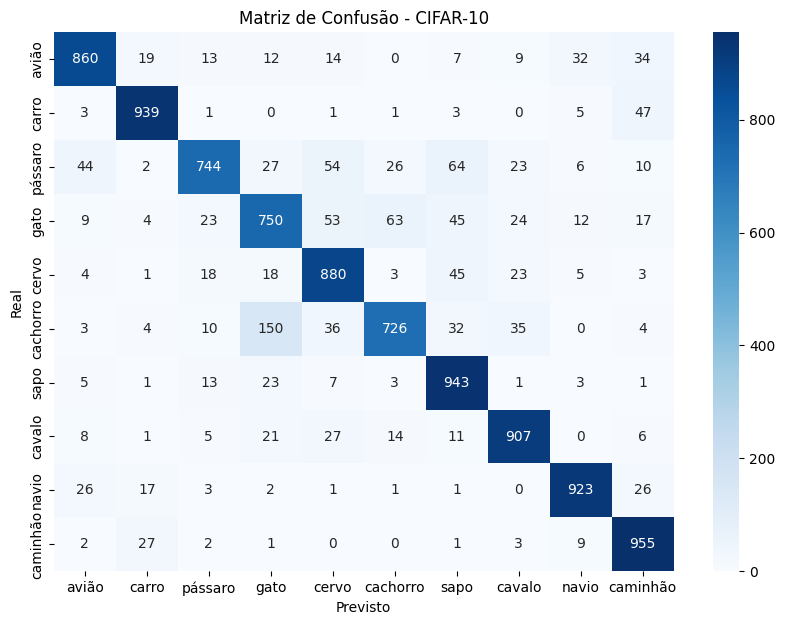

In [30]:
# ----------------------------
# 6. Avaliação no teste
# ----------------------------
test_loss, test_acc = modelo.evaluate(x_test, y_test_cat, verbose=0)
print(f"Acurácia no teste: {test_acc:.4f}")

# Predições
y_pred_proba = modelo.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Relatório
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusão - CIFAR-10")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

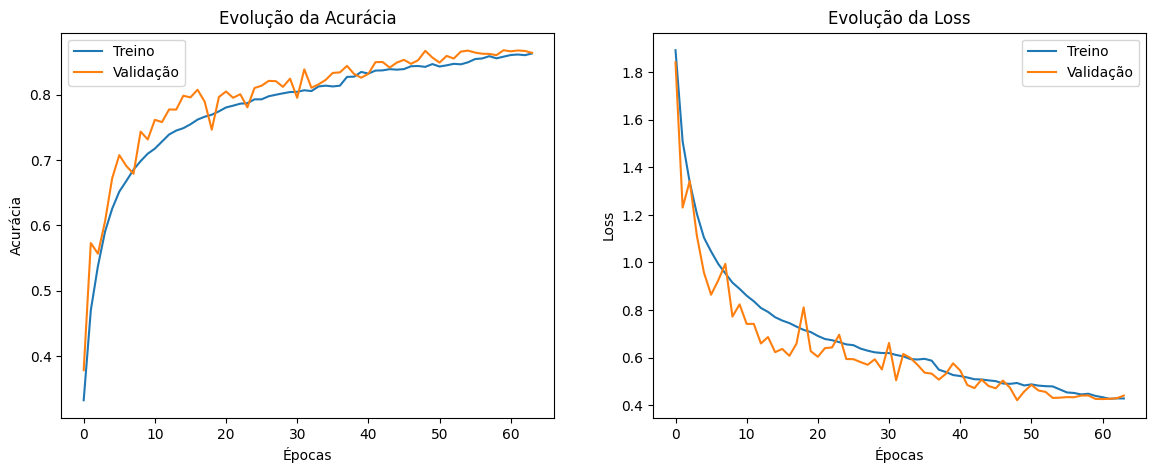

In [31]:
# ----------------------------
# 7. Curvas de treinamento
# ----------------------------
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title("Evolução da Acurácia")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title("Evolução da Loss")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

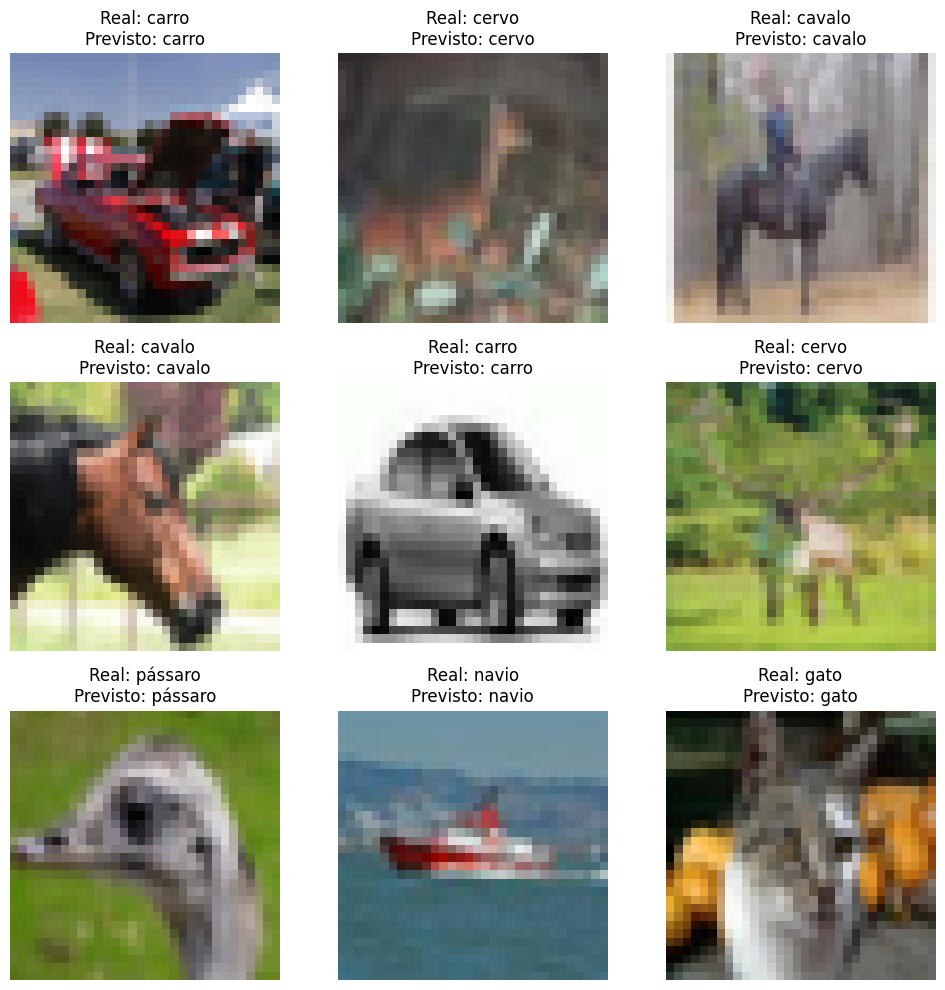

In [32]:
# ----------------------------
# 8. Visualização de predições
# ----------------------------
indices = np.random.choice(len(x_test), 9, replace=False)
plt.figure(figsize=(10,10))
for i, idx in enumerate(indices):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[idx])
    plt.axis("off")
    plt.title(f"Real: {class_names[y_true[idx]]}\nPrevisto: {class_names[y_pred[idx]]}")
plt.tight_layout()
plt.show()